### Computer Vision Assignment

#### Dataset is imported and full grain, broken grain and mixed grain images are kept in 3 separate folders namely Full_grain, Broken_grain and Mixed_grain respectively
The approach is we will use full grain and broken grain images for training and mixed grain for testing 

In [32]:
#Importing required libraries
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers
from keras.layers import Dropout

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

In [33]:
broken='Broken_grain/broken_grain_1.jpg'
full='Full_grain/full_grain_4.jpg'

In [34]:
def crop_resize_img(img):
#     print(type(img), img.shape)
    ht, wd= img.shape

    # create new image of desired size and color (black) for padding
    ww = 300
    hh = 300
    color = 0
    result = np.full((hh,ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img

    final =cv2.resize(result, (50,50))
    
    return final


### Data preprocessing

#### Method taking image path as input and giving contours as output along with saving each of the contours inside full_rice and broken rice folder

In [93]:
def pre_process_And_Count(image_path, output_path):
    # load input images for demonstration
    input_rice = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # local adaptive thresholding - computes local threshold based on given window size
    output_adapthresh = cv2.adaptiveThreshold (input_rice, 255.0, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, -20.0)

    cv2.imwrite('rice_adapthresh.png', output_adapthresh)

    # morphologial erosion - cleaning up binary images
    kernel = np.ones((5,5),np.uint8)
    output_erosion = cv2.erode(output_adapthresh, kernel)

    cv2.imwrite('rice_erosion.png', output_erosion)

    # Contours - Computes polygonal contour boundary of foreground objects
    # apply connected components on clean binary image
    contours, hierarchy = cv2.findContours(output_erosion, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE)
    output_contour = cv2.cvtColor(input_rice, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
    print("Number of detected contours", len(contours))
    # plt.imshow("Contours", output_contour)
    cv2.imwrite('rice_contours.png', output_contour)
    # plt.show()
    k=1
    temp = 0.70 * len(contours)
    for i in contours:
        x, y, width, height = cv2.boundingRect(i)
        roi = output_erosion[y:y+height, x:x+width]
        roi=crop_resize_img(roi)
        path  = ''
        if output_path !='mixed/mixed_':
            if k<temp:
                path = 'dataset/train/'+output_path

            else:
                path = 'dataset/test/'+output_path
        else:
            path = output_path
        cv2.imwrite(path+str(k)+".png", roi)
        k+=1


### Create a dataset folder in which bifurcate into train and test folder

In [94]:
#method to create directory
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [95]:
# dataset folder creation
create_directory('dataset')

In [96]:
# train folder creation 
create_directory('dataset/train')

In [97]:
# test folder creation
create_directory('dataset/test')

In [98]:
# full rice folder creation at train level
create_directory('dataset/train/full_rice')

In [99]:
# full rice folder creation at test level
create_directory('dataset/test/full_rice')

In [100]:
# broken rice folder creation at train level
create_directory('dataset/train/broken_rice')

In [101]:
# broken rice folder creation at test level
create_directory('dataset/test/broken_rice')

In [102]:
#preprocess and save the contours at specific path
pre_process_And_Count(full, 'full_rice/full_')

Number of detected contours 680


In [103]:
#preprocess and save the contours at specific path
pre_process_And_Count(broken, 'broken_rice/broken_')

Number of detected contours 650


#### Cutting and  moving some of the images from the train/full_rice to test/full_rice and train/broken_rice to test/broken_rice

In [104]:
# Creating image data generator
image_size = (50,50)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(50,50),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)


validation_generator = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)


Found 929 images belonging to 2 classes.
Found 401 images belonging to 2 classes.


In [105]:
train_generator.class_indices

{'broken_rice': 0, 'full_rice': 1}

In [106]:
a, b = next(train_generator)
a.shape

(32, 50, 50, 1)

In [107]:
img_width = 50
img_height = 50

# Check for TensorFlow or Thieno
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(50, 50, 1)

### Model creation

In [109]:
model = Sequential()
# Conv2D : Two dimenstional convulational model.
# 32 : Input for next layer
# (3,3) convulonational windows size
model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # Output convert into one dimension layer and will go to Dense layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

import keras
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=.0001),
              metrics=['accuracy'])

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=2)

Epoch 1/200
10/10 [==============================] - 1s 150ms/step - loss: 0.6870 - accuracy: 0.5813 - val_loss: 0.6810 - val_accuracy: 0.7500
Epoch 2/200
10/10 [==============================] - 1s 135ms/step - loss: 0.6806 - accuracy: 0.6594 - val_loss: 0.6929 - val_accuracy: 0.4844
Epoch 3/200
10/10 [==============================] - 1s 122ms/step - loss: 0.6855 - accuracy: 0.5952 - val_loss: 0.6820 - val_accuracy: 0.5781
Epoch 4/200
10/10 [==============================] - 1s 140ms/step - loss: 0.6715 - accuracy: 0.6219 - val_loss: 0.6902 - val_accuracy: 0.5625
Epoch 5/200
10/10 [==============================] - 1s 140ms/step - loss: 0.6585 - accuracy: 0.6781 - val_loss: 0.6671 - val_accuracy: 0.6094
Epoch 6/200
10/10 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.66 - 1s 135ms/step - loss: 0.6674 - accuracy: 0.6625 - val_loss: 0.7195 - val_accuracy: 0.5469
Epoch 7/200
10/10 [==============================] - 1s 139ms/step - loss: 0.6610 - accuracy: 0.6219

Epoch 58/200
10/10 [==============================] - 2s 175ms/step - loss: 0.4204 - accuracy: 0.8406 - val_loss: 0.4898 - val_accuracy: 0.7500
Epoch 59/200
10/10 [==============================] - 2s 159ms/step - loss: 0.3551 - accuracy: 0.8651 - val_loss: 0.5725 - val_accuracy: 0.6875
Epoch 60/200
10/10 [==============================] - 2s 185ms/step - loss: 0.4307 - accuracy: 0.8156 - val_loss: 0.6963 - val_accuracy: 0.6406
Epoch 61/200
10/10 [==============================] - 71s 7s/step - loss: 0.3701 - accuracy: 0.8408 - val_loss: 0.5585 - val_accuracy: 0.7031
Epoch 62/200
10/10 [==============================] - 2s 151ms/step - loss: 0.4411 - accuracy: 0.7682 - val_loss: 0.4206 - val_accuracy: 0.8125
Epoch 63/200
10/10 [==============================] - 2s 228ms/step - loss: 0.3604 - accuracy: 0.8313 - val_loss: 0.4657 - val_accuracy: 0.8125
Epoch 64/200
10/10 [==============================] - 2s 206ms/step - loss: 0.4092 - accuracy: 0.7969 - val_loss: 0.7076 - val_accuracy: 0

10/10 [==============================] - 1s 133ms/step - loss: 0.3375 - accuracy: 0.8547 - val_loss: 0.4730 - val_accuracy: 0.8125
Epoch 115/200
10/10 [==============================] - 2s 157ms/step - loss: 0.4037 - accuracy: 0.8062 - val_loss: 0.5635 - val_accuracy: 0.7031
Epoch 116/200
10/10 [==============================] - 1s 149ms/step - loss: 0.3425 - accuracy: 0.8500 - val_loss: 0.4366 - val_accuracy: 0.7500
Epoch 117/200
10/10 [==============================] - 2s 156ms/step - loss: 0.4240 - accuracy: 0.8125 - val_loss: 0.5690 - val_accuracy: 0.7500
Epoch 118/200
10/10 [==============================] - 1s 141ms/step - loss: 0.3281 - accuracy: 0.8719 - val_loss: 0.5253 - val_accuracy: 0.7656
Epoch 119/200
10/10 [==============================] - 2s 168ms/step - loss: 0.3355 - accuracy: 0.8594 - val_loss: 0.4625 - val_accuracy: 0.8125
Epoch 120/200
10/10 [==============================] - 119s 12s/step - loss: 0.3703 - accuracy: 0.8313 - val_loss: 0.5508 - val_accuracy: 0.7031

10/10 [==============================] - 2s 209ms/step - loss: 0.3376 - accuracy: 0.8512 - val_loss: 0.4983 - val_accuracy: 0.7969
Epoch 171/200
10/10 [==============================] - 3s 296ms/step - loss: 0.3367 - accuracy: 0.8625 - val_loss: 0.5874 - val_accuracy: 0.7188
Epoch 172/200
10/10 [==============================] - 2s 238ms/step - loss: 0.3710 - accuracy: 0.8219 - val_loss: 0.3677 - val_accuracy: 0.8438
Epoch 173/200
10/10 [==============================] - 2s 205ms/step - loss: 0.3465 - accuracy: 0.8656 - val_loss: 0.4226 - val_accuracy: 0.7500
Epoch 174/200
10/10 [==============================] - 2s 187ms/step - loss: 0.3890 - accuracy: 0.8406 - val_loss: 0.4030 - val_accuracy: 0.8281
Epoch 175/200
10/10 [==============================] - 2s 192ms/step - loss: 0.3495 - accuracy: 0.8512 - val_loss: 0.6887 - val_accuracy: 0.7188
Epoch 176/200
10/10 [==============================] - 2s 160ms/step - loss: 0.3791 - accuracy: 0.8374 - val_loss: 0.3991 - val_accuracy: 0.7969

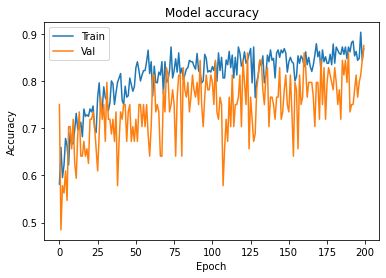

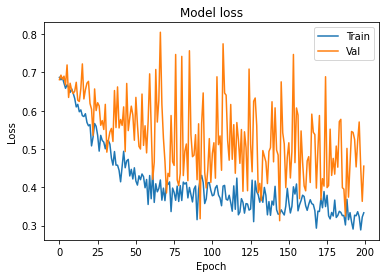

In [110]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#### User CLI input of path of image

In [111]:
# create a mixed folder
create_directory('mixed')

In [112]:
mixed = input()

Mixed_grain/mixed_grain_1.jpg


In [113]:
# count on test image
# Given below the tested image path for me
# mixed='Mixed_grain/mixed_grain_1.jpg'
pre_process_And_Count(mixed, 'mixed/mixed_')

Number of detected contours 364


In [114]:
import os
from os import listdir
from os.path import isfile, join

In [115]:
# {'broken_rice': 0, 'full_rice': 1}

predict_dir_path='mixed/'
onlyfiles = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]

# predicting images
from keras.preprocessing import image
full = 0 
broken  = 0
for file in onlyfiles:
    img = image.load_img(predict_dir_path+'/'+file, target_size=(img_width, img_height), grayscale=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size=32)
    classes = classes[0][0]
    if classes == 0:
        broken += 1
    else:
        full += 1
    
print("Total full :",full)
print("Total broken :",broken)

Total full : 256
Total broken : 108


### Result 

In [116]:
print("Total rice grains-", (broken+full))
print('Percent of broken rice-', broken/(broken+full))

Total rice grains- 364
Percent of broken rice- 0.2967032967032967
